In [2]:
import os 
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor as RFR

# 特征选择
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectFromModel

from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, r2_score

# 导入相关模型
from xgboost import XGBRegressor as XGB
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import HuberRegressor as HuberR, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor as RFR, AdaBoostRegressor as ABR, GradientBoostingRegressor as GBDT, BaggingRegressor as BagR

# 数据探索

## 相关函数定义

In [14]:
def miss_count(data):
    "函数功能：根据传入的data进行各特征的缺失统计并返回"
    missing = data.isnull().sum(axis = 0).sort_values(ascending = False)
    miss_count = pd.DataFrame([missing.index, missing.values]).T
    # 修改列索引的类型以便修改列名
    miss_count.columns = miss_count.columns.astype(str)
    # 计算缺失率
    miss_count["miss_proportion"] = miss_count.iloc[:, 1] / data.shape[0] # 等价于miss_count.iloc[:, 1].mean()
    miss_count.rename(columns = {"0":"features", "1": "miss_count"}, inplace = True)
    miss_count
    
    return miss_count

In [31]:
def draw_plot(data, fig = (20, 35), draw_box = True):
    """
    函数功能：根据传入的data来绘制各个特征的箱线图/核密度图以观察各特征的离散情况/数据分布；
    fig:设置画布的大小---只绘制一幅图像时无需设置；
    draw_box:选择是绘制箱线图还是核密度图，默认是箱线图；
    """
    # 先将数据转为dataframe格式
    data = pd.DataFrame(data)
    feature_names = data.columns.tolist()
    
    # 只绘制一副图时
    if len(feature_names) == 1:
        plt.figure(figsize = (12, 8))     
        # 绘制箱线图
        if draw_box:
            sns.boxplot(data = data.loc[:, feature_names[0]], orient = "V")
            plt.xlabel(feature_names[0], fontsize = 15)
            plt.xticks([])
        # 绘制核密度图
        else:
            sns.kdeplot(data.loc[:, feature_names[0]].astype("float"), shade = True)
            plt.title(feature_names[0], fontsize = 15)
            plt.xlabel("")
            plt.ylabel("")
            
     # 绘制多幅子图时
    else:
        # 调整子图间距
        cols = 3
        rows = int(np.ceil(len(feature_names) / cols))
        plt.subplots_adjust(hspace = 3, wspace = .8)
        plt.figure(figsize = fig, dpi = 200)
        
        # 使用箱线图查看各特征的离散情况
        for i, feature in enumerate(feature_names):
            plt.subplot(rows, cols, i + 1)
            
            try:
                if draw_box:
                    sns.boxplot(data = data.loc[:, feature], orient = "V")
                    plt.xlabel(feature_names[i], fontsize = 15)
                    plt.xticks([])
                else:
                    sns.kdeplot(data.loc[:, feature].astype("float"), shade = True)
                    plt.title(feature_names[i], fontsize = 15)    
                    plt.xlabel("")
                    plt.ylabel("")
                    
            except UserWarning:
                continue

    plt.show()
    
    return

In [104]:
# 定义一个使用随机森林来填补缺失值的函数
def impute_of_rf(data, miss_fea_list):
    """
    函数功能：使用随机森林来填补所传data(是一个dataframe)中的所有缺失项；
    miss_fea_list:含有缺失的所有特征组成的一个列表容器，其中按缺失占比大小进行升序排序以便从缺失最少的列开始填起；
    """
    
    if len(miss_fea_list) < 1:
        print("请传入长度至少为1的列表")
        return
    
    for feature in miss_fea_list:
        x_rf = data.copy()
            
        # 以缺失列作为标签y,其余特征作为特征x
        # 待填充列
        fill_col = x_rf.loc[:, feature]
        # 分别获取为值为空和非空所在行索引---提取x_train, y_train(使用notnull_idx), x_test(使用is_null_idx),
        is_null_idx = fill_col[fill_col.isnull()].index
        notnull_idx = fill_col[fill_col.notnull()].index
        
        # 提出x_train, x_test, ytrain
        x_train = x_rf.iloc[notnull_idx, x_rf.columns != feature]
        x_test = x_rf.iloc[is_null_idx, x_rf.columns != feature]
        y_train = x_rf.iloc[notnull_idx].loc[:, feature]
        
        # 先将x_train, x_test中的缺失值使用0填充保证特征矩阵中无缺失项再放入模型训练及预测
        impute_0 = SimpleImputer(strategy = "constant", fill_value = 0).fit(x_train)
        x_train = impute_0.transform(x_train)
        x_test = impute_0.transform(x_test)
        
        # 使用随机森林填补缺失值
        rf = RFR(random_state = 72).fit(x_train, y_train)
        pred = rf.predict(x_test)
        data.loc[data.iloc[is_null_idx].index, feature] = pred
        
    return

In [357]:
def distribution_comp(data_list, label_list):
    """
    函数功能：对比使用不同缺失值填补策略得到的新数据与原始数据的数据分布差异；
    Params:
    data_list:使用不同的添补方法得到的数据---只需要进行了缺失值填充的特征；
    label_list:所填补的缺失列对应名称；
    """
    fig = plt.figure(figsize = (30, 20))
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    col_names = data_iacs_miss_count["features"][:3].tolist()
    color_l = ["tan", "lime", "turquoise", "hotpink", "mediumpurple"]
    
    for i, ax in enumerate([ax1, ax2, ax3]):
        k = 0
        for dat in data_list:
            shade = False
            color = color_l[k]
            if k == 0:
                shade = True
                color = "red"
            sns.kdeplot(dat.iloc[:, i], shade = shade, label = label_list[k], ax = ax, linewidth = 4, color = color)
            k += 1
      #  ax.legend(fontsize = 30)
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_title("{}".format(col_names[i]), fontsize = 40)
       # ax.grid(b = True, linestyle = "-", linewidth = 3, axis = "y")

    fig.legend(label_list[1:]+[label_list[0]], fontsize = 30)
    plt.suptitle("Comparison of different filling effects", fontsize = 45)
    
    plt.show()
    
    return

In [414]:
def multi_models_predict(x_train, x_test, y_train, y_test, target_name = None, return_test = False, rand_ = 72):
    """
    函数功能：根据传入的训练与测试数据放入不同的模型中分别进行测试并计算其对应的MAE, MAPE和R^2值并以dataframe形式返回；
    target_name:为标签名称，可不填；
    return_test:是否返回模型在测试集上的预测情况---MAE，MAPE；
    """
    # 实例化
    ridge = Ridge(max_iter=1e4)
    lasso = Lasso(max_iter=1e4)
    huber = HuberR(max_iter=1e4)
    linear_svr = LinearSVR(max_iter = 1e4, random_state =rand_)
    svr = SVR()
    rf = RFR(random_state = rand_)
    ada = ABR(random_state = rand_, n_estimators = 100)
    gbdt = GBDT(random_state = rand_)
    bag = BagR(random_state = rand_, n_estimators = 100)
    xgb = XGB(random_state = rand_, n_estimators = 100)
    knn = KNN()

    # 模型训练及预测
    train_scores_list = []
    validate_scores_list = []
    test_scores_list = []
    
    model_names = ["Ridge", "Lasso", "Huber", "Linear_SVR", "SVR", "RandomForest", "AdaBoost", "GBDT", "Bagging", "XGBoost", "KNN"]
        
    if return_test:
        for model in [ridge, lasso, huber, linear_svr, svr, rf, ada, gbdt, bag, xgb, knn]:
            scores = []
            pred = model.fit(x_train, y_train).predict(x_test)
            for func in [mae, mape]:
                scores.append(func(y_test, pred))
            test_scores_list.append(scores)
        cols = ["(Test) MAE", "MAPE"]
        if target_name:
            cols = ["(" + target_name + "_Test) MAE", "MAPE"]
        df = pd.DataFrame(test_scores_list, index = model_names, columns = cols)
        
        return df 
    
    else:
        cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
        for model in [ridge, lasso, huber, linear_svr, svr, rf, ada, gbdt, bag, xgb, knn]:
            res = cross_validate(estimator = model
                                , X = x_train
                                , y = y_train
                                , cv = cv
                                , n_jobs = 32
                                , return_train_score = True
                                , scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "r2"]
                                )
            train_scores_list.append([abs(res["train_neg_mean_absolute_error"].mean()), 
                                      abs(res["train_neg_mean_absolute_percentage_error"].mean()), 
                                      res["train_r2"].mean()
                                     ])
            validate_scores_list.append([abs(res["test_neg_mean_absolute_error"].mean()), 
                                        abs(res["test_neg_mean_absolute_percentage_error"].mean()), 
                                        res["test_r2"].mean()
                                        ])
        cols = ["(Train) MAE", "MAPE", "R^2"]
        if target_name:
            cols = [target_name + "_Train MAE", "MAPE", "R^2"]
        train_df = pd.DataFrame(train_scores_list, index = model_names, columns = cols)
        if target_name:
            cols = [target_name + "_Validate MAE", "MAPE", "R^2"]
        validate_df = pd.DataFrame(validate_scores_list, index = model_names, columns = cols)
        
        return train_df, validate_df

In [402]:
def data_split(x, y, distri_comp, test_size = 0.2, rand_ = 72):
    """
    函数功能：实现训练集和测试集的划分
    distri_comp:是否绘制数据分布对比图；
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = rand_)
    x_train.index, x_test.index, y_train.index, y_test.index = range(len(x_train)), range(len(x_test)), range(len(y_train)), range(len(y_test))
    if distri_comp:
        plt.figure(figsize = (10, 6))
        colors = ["red", "blue", "limegreen"]
        labels = ["y_full", "y_train", "y_test"]

        for i, dat in enumerate([y, y_train, y_test]):
            shade = False
            if i == 0:
                shade = True
            sns.kdeplot(dat, shade = shade, color = colors[i], label = labels[i])
        plt.legend(fontsize = 12)
        plt.title("Data distribution comparison", fontsize = 25)
        
        plt.show()
    
    return x_train, x_test, y_train, y_test

In [588]:
def train_validate_comp(train_df, validate_df, dataset_name):
    """
    函数功能：根据各模型在交叉验证中的训练和验证结果绘制对比图，分别是在MAE，MAPE和R^2上的训练验证对比；
    Params:
        tarin_df、validate_df：训练及验证集的结果，三列分别对应MAE，MAPE，R^2；
        dataset_name：图的标题；
    """
    fig = plt.figure(figsize = (16, 9))
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    labels = ["Train", "Validate"]
    score_names = ["MAE", "MAPE", "R^2"]

    for i, ax in enumerate([ax2, ax3, ax1]):
        for j, dat in enumerate([train_df, validate_df]):
            ax.plot(dat.iloc[:, i], label = labels[j] + "_" + score_names[i])
            if i == 2:
                # 标记R2最大值点
                idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].max())
                y_max = dat.iloc[:, i].max()
                ax.plot(idx, y_max, marker = "*", color = "red", markersize = 12, alpha = .7)
                if j == 0:
                    ax.text(idx-0.2, y_max+0.05, round(y_max, 7), fontsize = 14)
                else:
                    ax.text(idx-0.2, y_max-0.1, round(y_max, 7), fontsize = 14)
                ax.tick_params("x", labelsize = 12)
            else:
                # 标记最小值点---MAE、MAPE
                idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
                ax.plot(idx, dat.iloc[:, i].min(), marker = "*", color = "red", markersize = 11, alpha = .7)
                if i == 0:
                    ax.text(idx - 0.8, dat.iloc[:, i].min() + 0.3, round(dat.iloc[:, i].min(),7), fontsize = 12)
                else:
                    ax.text(idx - 0.45, dat.iloc[:, i].min() + 0.005, round(dat.iloc[:, i].min(),7), fontsize = 12)
        if i != 2:
            ax.tick_params("x", rotation = 45, labelsize = 11)
        ax.legend(fontsize = 16)
    plt.suptitle(dataset_name, fontsize = 20)
    plt.show()
    
    return 

## 导入数据

In [3]:
path = r"C:\Users\Research Center\Desktop\learning\PW770建模\对标签YS&IACS建模分析\1.建模数据处理"
data = pd.read_excel(os.path.join(path, "data1.xlsx"))
data

,Cr,Fe,Ti,Si,Ni,固溶温度,固溶时间min,1级冷轧变形率,1级时效温度,1级时效时间h,2级冷轧变形率,2级时效温度,2级时效时间h,YS,IACS%
0,0.0005,0.0007,0.2147,0.01205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0005,0.0007,0.2147,0.01205,NaN,850.0,0.5,0.200,450.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0.0005,0.0007,0.2147,0.01205,NaN,850.0,0.5,0.200,450.0,1.0,NaN,NaN,NaN,NaN,NaN
3,0.0005,0.0007,0.2147,0.01205,NaN,850.0,0.5,0.200,450.0,2.0,NaN,NaN,NaN,NaN,NaN
4,0.0005,0.0007,0.2147,0.01205,NaN,850.0,0.5,0.200,450.0,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.8505,0.3346,0.1950,0.02890,NaN,1045.0,2.5,0.750,450.0,9.0,0.667,350.0,11.0,667.0,67.9
1067,0.8505,0.3346,0.1950,0.02890,NaN,1045.0,2.5,0.667,450.0,9.0,0.667,350.0,7.0,680.0,64.6
1068,0.8505,0.3346,0.1950,0.02890,NaN,1045.0,2.5,0.667,450.0,9.0,0.667,350.0,9.0,669.0,69.9
1069,0.8505,0.3346,0.1950,0.02890,NaN,1045.0,2.5,0.667,450.0,9.0,0.667,350.0,11.0,658.0,69.9


In [9]:
# 去除重复值 
data = data.drop_duplicates()
# 更新索引
data.index = range(len(data))
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cr,1034.0,0.664578,0.349519,0.000100,0.446750,0.79945,0.954700,1.4330
Fe,1019.0,0.338038,0.188306,0.000700,0.220550,0.29210,0.410000,0.9167
Ti,1034.0,0.179586,0.100400,0.003000,0.088900,0.21480,0.229600,0.4172
Si,1015.0,0.036724,0.024519,0.001900,0.021150,0.03030,0.038600,0.1084
Ni,281.0,0.103891,0.164181,0.002600,0.002600,0.11710,0.119000,1.0550
固溶温度,1016.0,979.040354,84.353755,800.000000,850.000000,1040.00000,1040.000000,1045.0000
固溶时间min,1016.0,1.729823,0.847533,0.500000,1.000000,2.00000,2.000000,10.0000
1级冷轧变形率,920.0,0.544204,0.173995,0.200000,0.400000,0.62500,0.625000,0.8500
1级时效温度,920.0,451.173913,16.039674,400.000000,450.000000,450.00000,450.000000,500.0000
1级时效时间h,920.0,5.751630,2.940468,0.000000,3.000000,6.00000,8.000000,12.0000


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Cr       1034 non-null   float64
 1   Fe       1019 non-null   float64
 2   Ti       1034 non-null   float64
 3   Si       1015 non-null   float64
 4   Ni       281 non-null    float64
 5   固溶温度     1016 non-null   float64
 6   固溶时间min  1016 non-null   float64
 7   1级冷轧变形率  920 non-null    float64
 8   1级时效温度   920 non-null    float64
 9   1级时效时间h  920 non-null    float64
 10  2级冷轧变形率  556 non-null    float64
 11  2级时效温度   546 non-null    float64
 12  2级时效时间h  546 non-null    float64
 13  YS       398 non-null    float64
 14  IACS%    543 non-null    float64
dtypes: float64(15)
memory usage: 121.3 KB


## 缺失值统计

In [15]:
# 初始缺失情况统计
miss_count(data)

,features,miss_count,miss_proportion
0,Ni,753,0.72824
1,YS,636,0.615087
2,IACS%,491,0.474855
3,2级时效温度,488,0.471954
4,2级时效时间h,488,0.471954
5,2级冷轧变形率,478,0.462282
6,1级冷轧变形率,114,0.110251
7,1级时效温度,114,0.110251
8,1级时效时间h,114,0.110251
9,Si,19,0.018375


## 探索数据离散情况

In [29]:
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-darkgrid")

<Figure size 432x288 with 0 Axes>

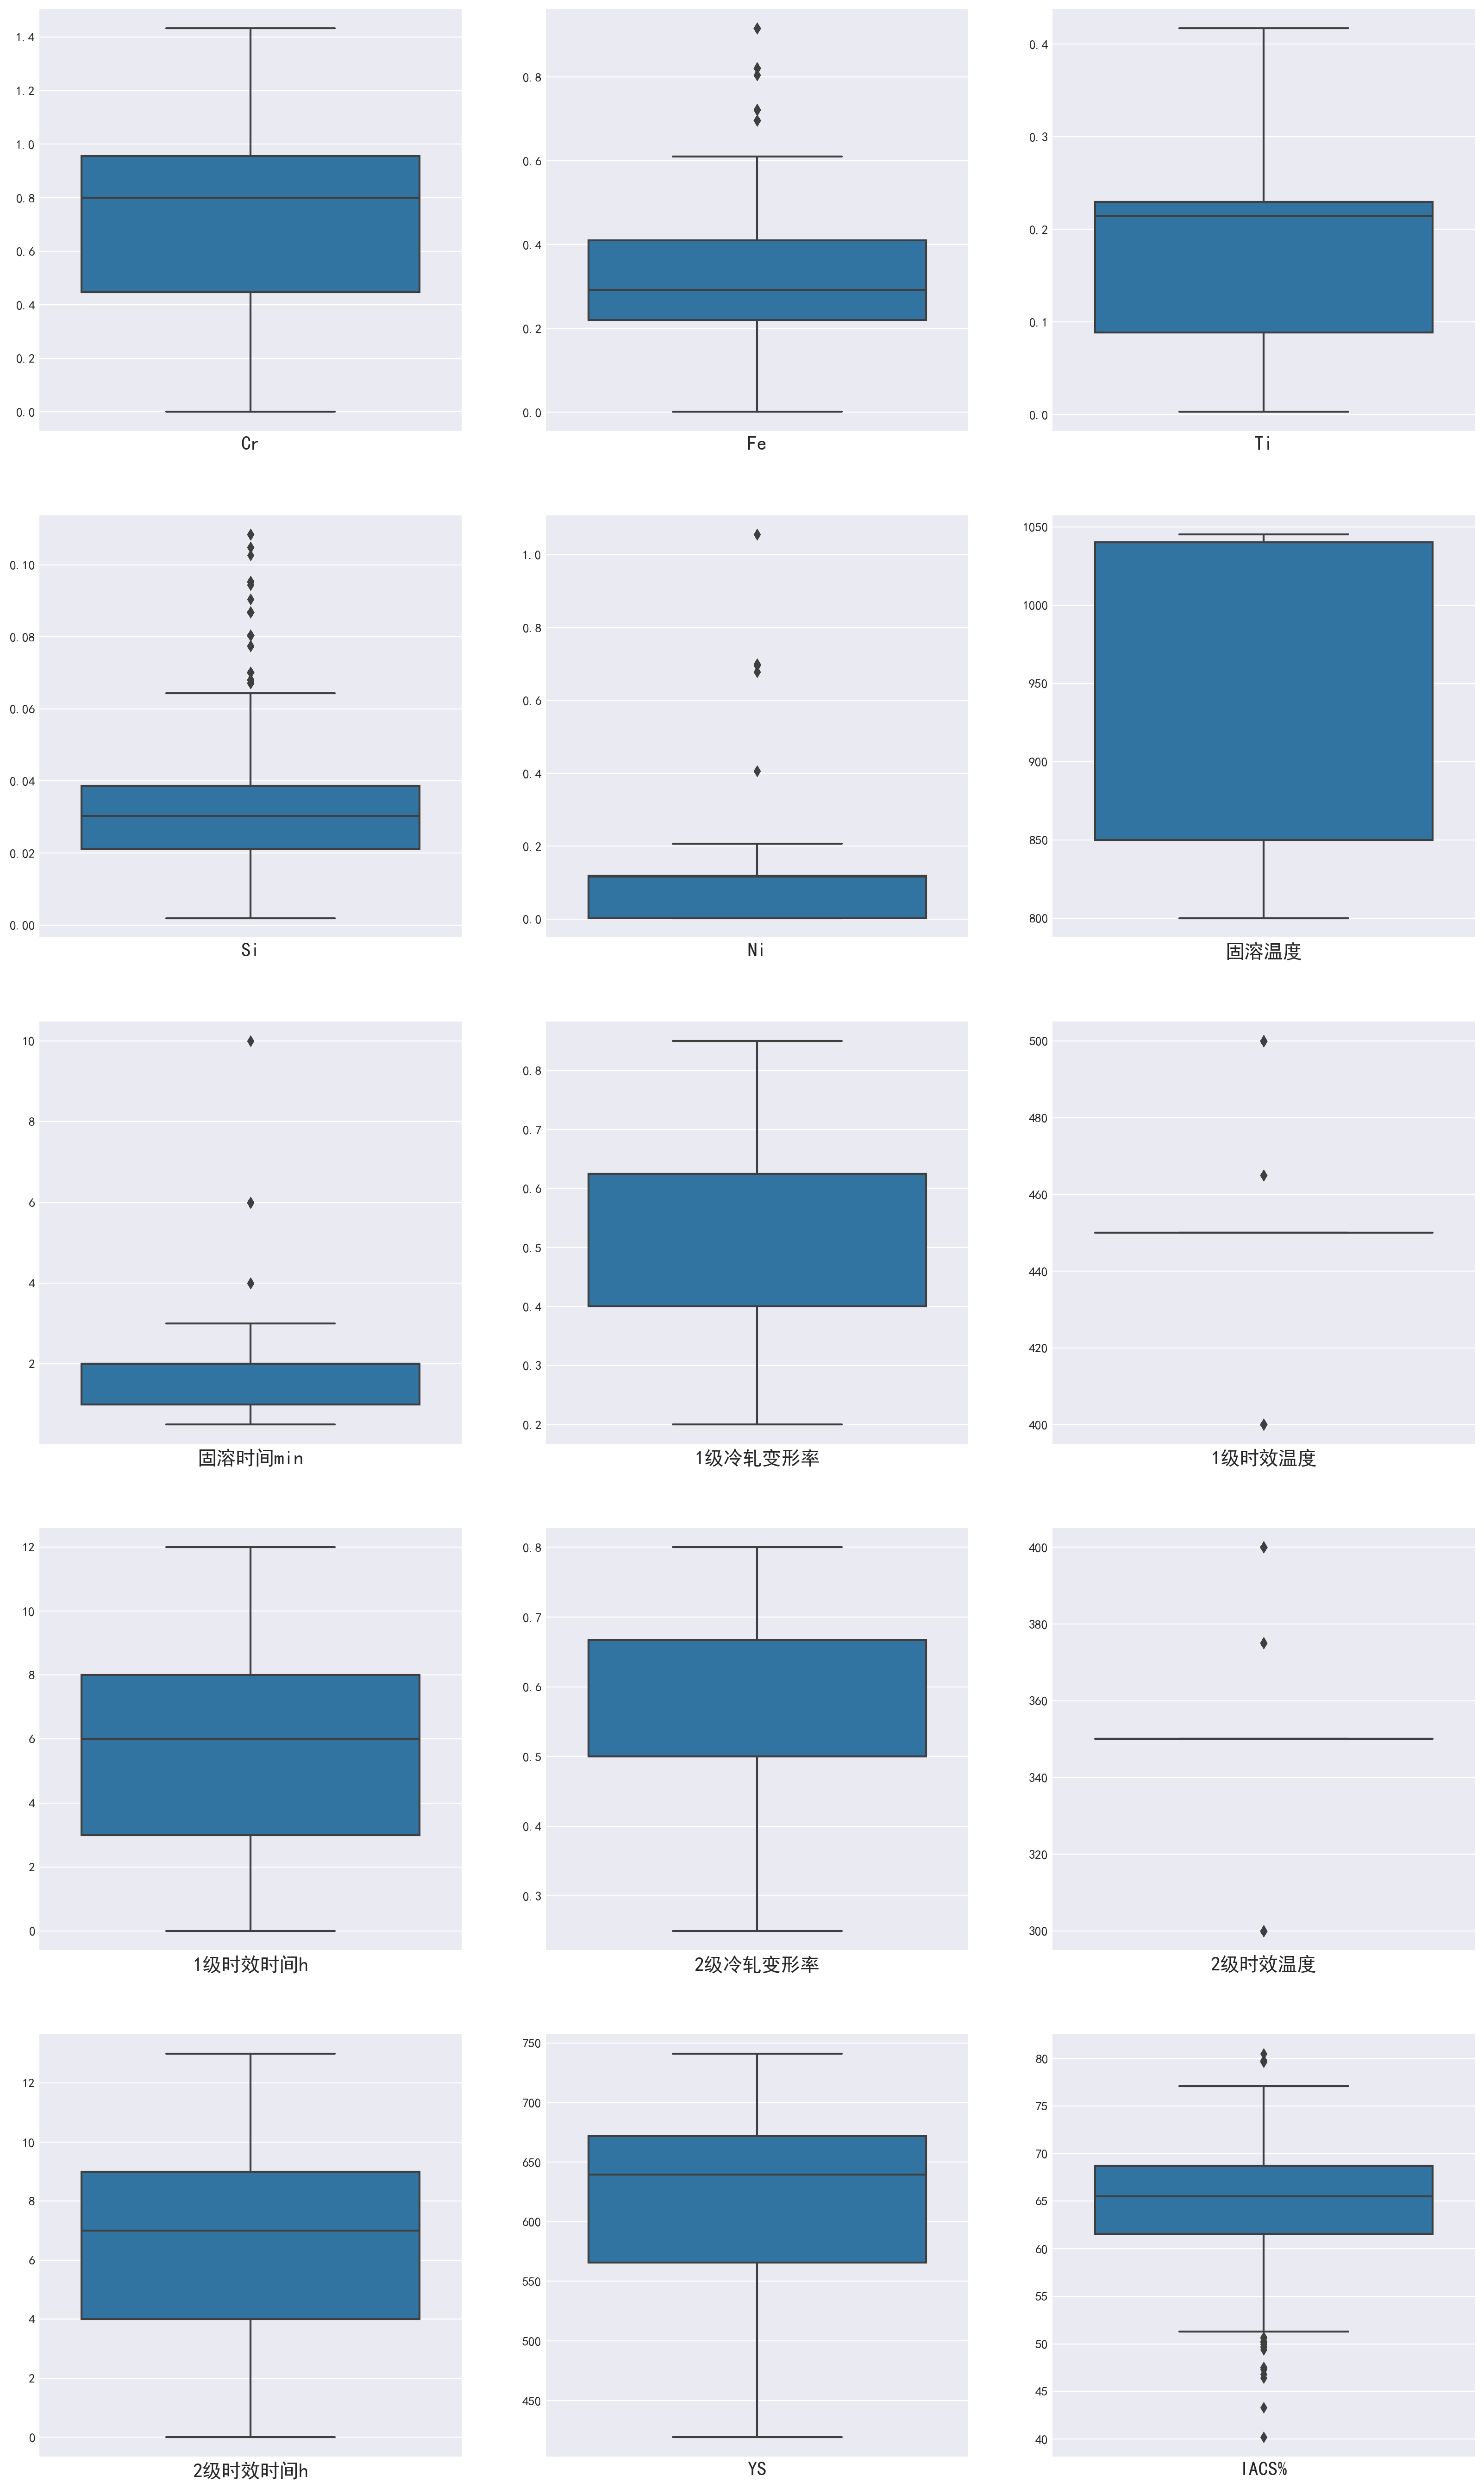

In [32]:
draw_plot(data)

<Figure size 432x288 with 0 Axes>

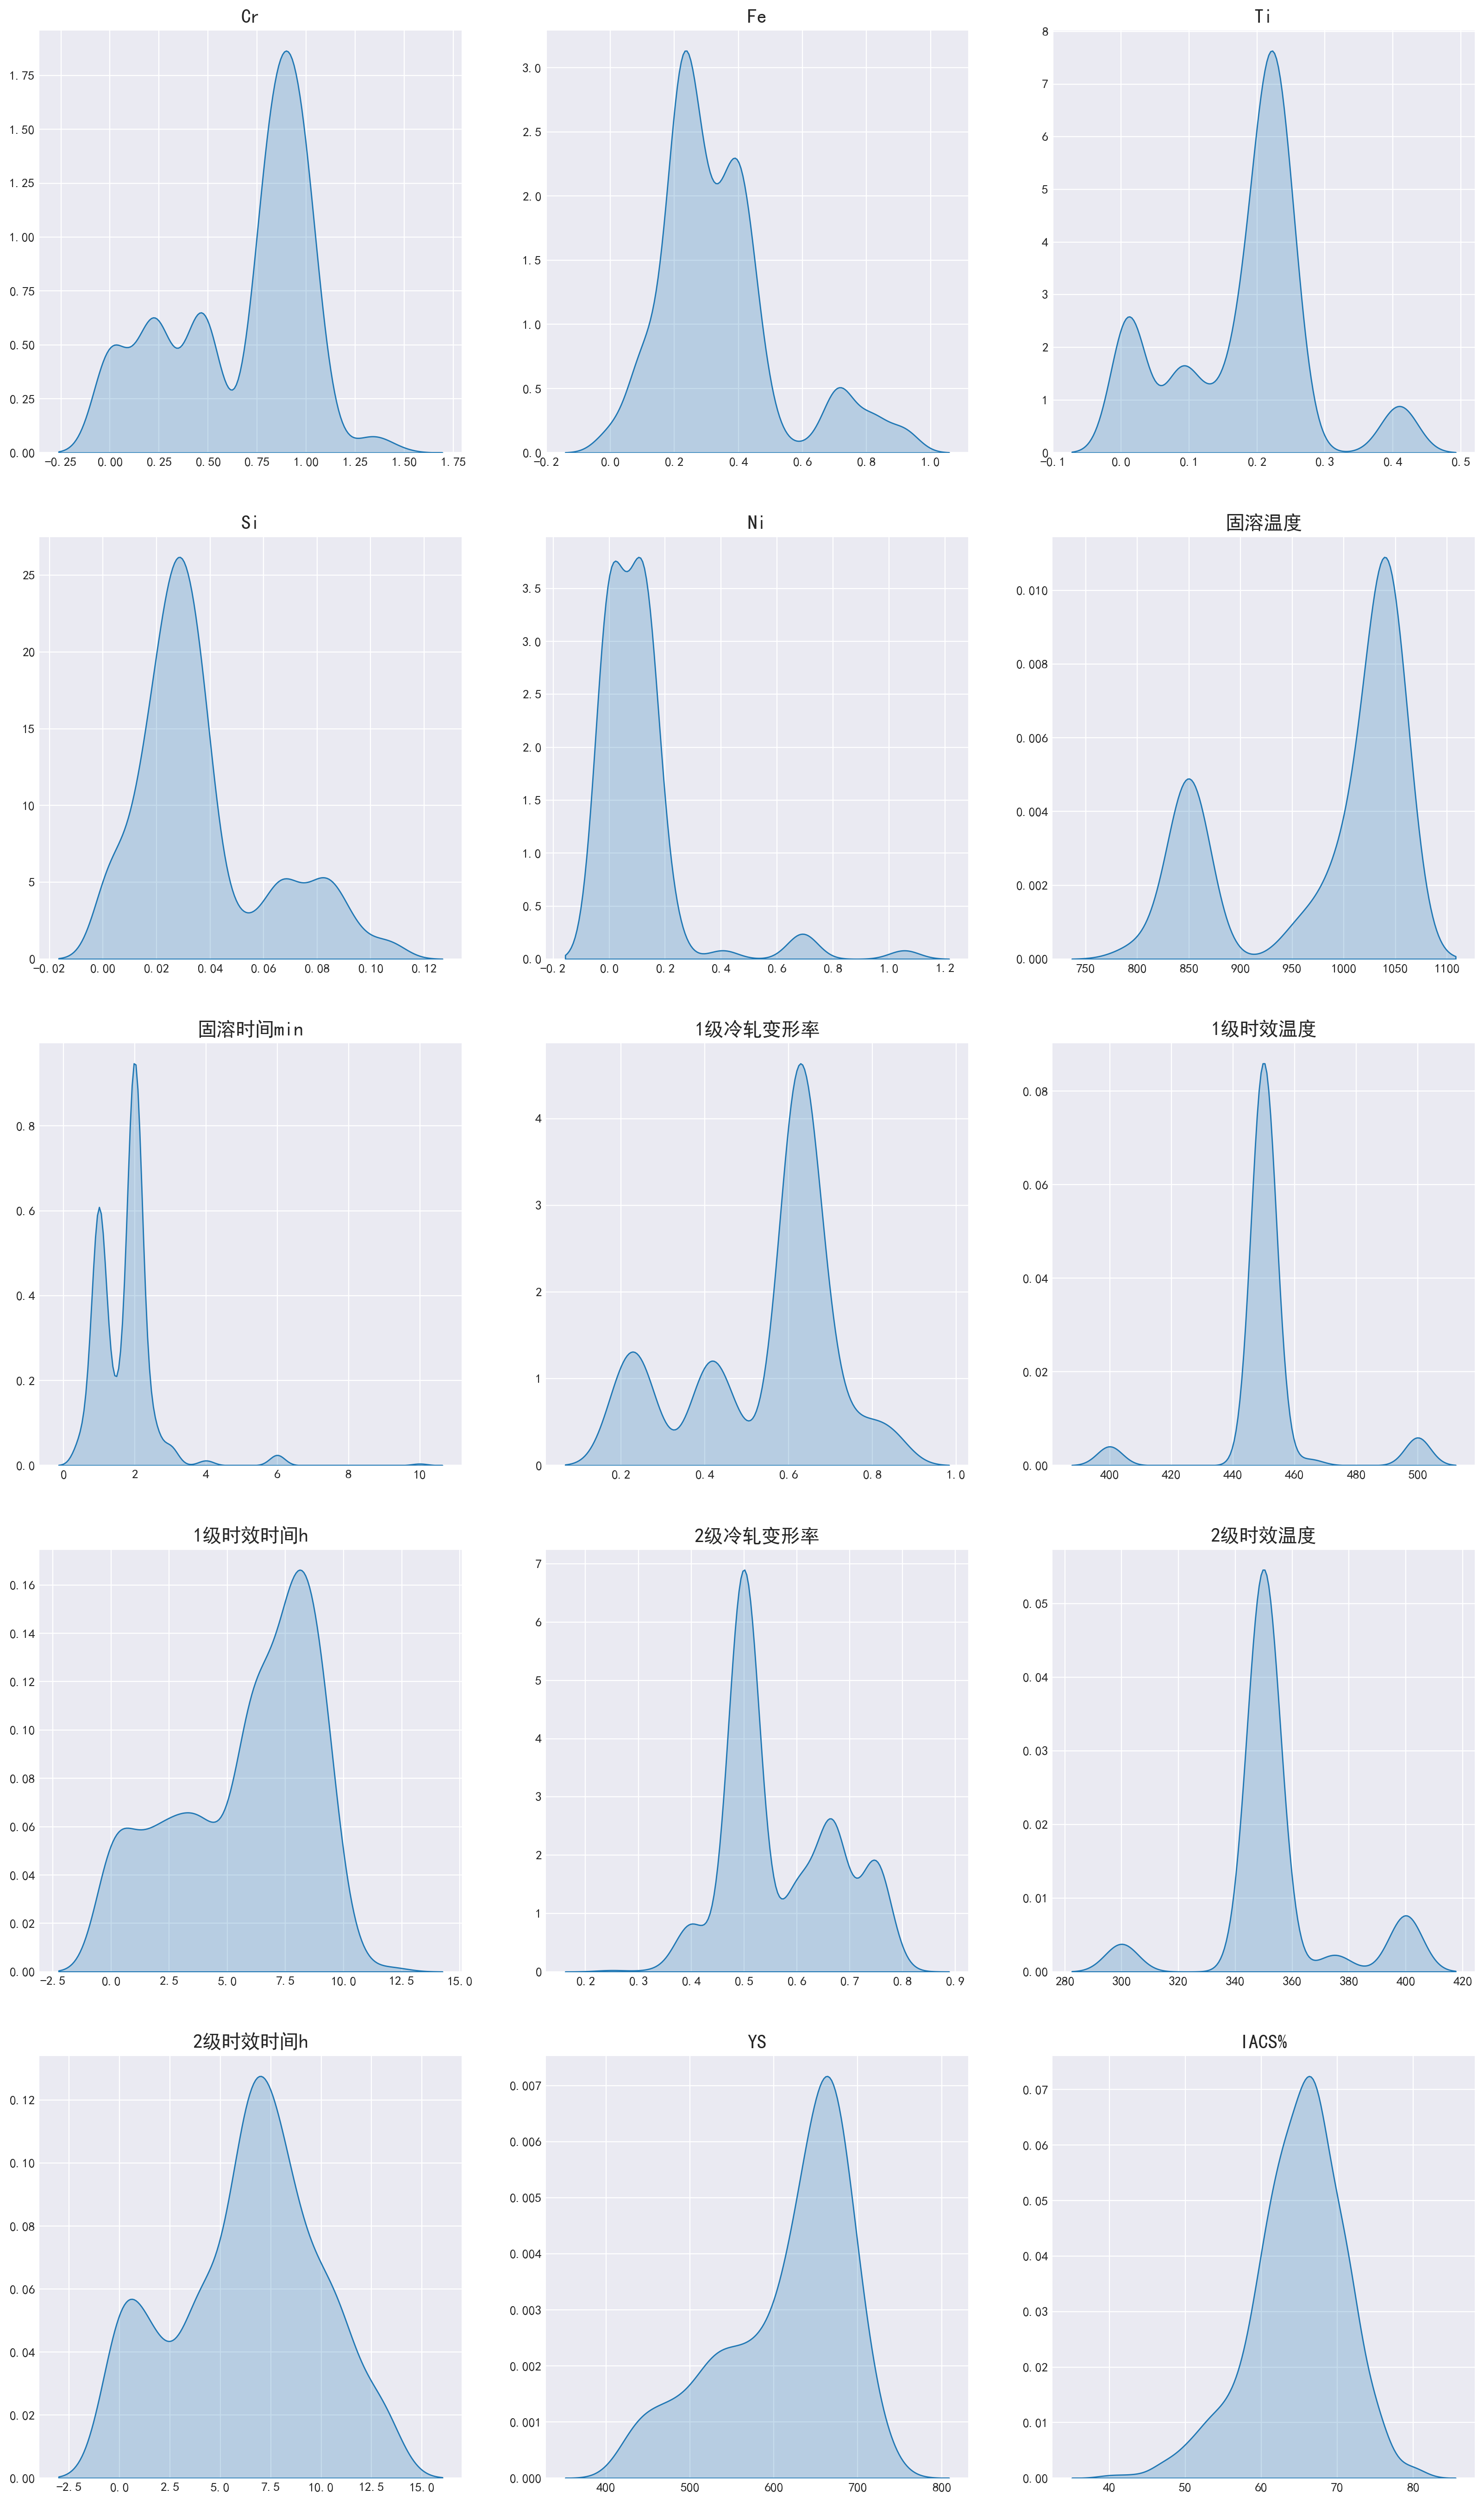

In [33]:
draw_plot(data, draw_box = False)

## 删除标签中的缺失项

In [109]:
data_iacs = data.loc[:, ~data.columns.isin(["YS"])]
data_ys = data.loc[:, ~data.columns.isin(["IACS%"])]

In [110]:
### 分别删除两个数据集中标签列中的缺失项
data_iacs = data_iacs.iloc[(data_iacs.iloc[:, -1].dropna()).index, :]
data_ys = data_ys.iloc[(data_ys.iloc[:, -1].dropna()).index, :]
# 更新索引
data_iacs.index = range(len(data_iacs))
data_ys.index = range(len(data_ys))
len(data_iacs), len(data_ys)

(543, 398)

## 缺失值处理

### 对数据data_iacs的缺失值处理

In [67]:
# 统计data_iacs中的缺失值
data_iacs_miss_count = count_null(data_iacs)
data_iacs_miss_count

,features,miss_count,miss_proportion
0,Ni,383,0.705341
1,Si,19,0.034991
2,Fe,15,0.027624
3,Cr,0,0.0
4,Ti,0,0.0
5,固溶温度,0,0.0
6,固溶时间min,0,0.0
7,1级冷轧变形率,0,0.0
8,1级时效温度,0,0.0
9,1级时效时间h,0,0.0


In [113]:
# ======== 使用不同缺失值填充后的效果对比 ========
# 使用0填充
data_iacs_0 = data_iacs.fillna(0)

data_iacs_miss_mean = data_iacs[data_iacs_miss_count["features"][:3]]
data_iacs_miss_median = data_iacs_miss_mean.copy()
for col in data_iacs_miss.columns:
    # 使用均值填充
    data_iacs_miss_mean.loc[:, col].fillna(data_iacs_miss_mean.loc[:, col].mean(), inplace = True)
    # 使用中值填充
    data_iacs_miss_median.loc[:, col].fillna(data_iacs_miss_median.loc[:, col].median(), inplace = True)
    
data_iacs_mean = pd.concat([data_iacs_miss_mean, data_iacs[data_iacs_miss_count["features"][3:]]], axis = 1)
data_iacs_median = pd.concat([data_iacs_miss_median, data_iacs[data_iacs_miss_count["features"][3:]]], axis = 1)

In [285]:
# 使用随机森林填充
data_iacs_reg = data_iacs.copy()
miss_cols = data_iacs_miss_count.sort_values(by = "miss_proportion").iloc[-3:]["features"].tolist()
impute_of_rf(data_iacs_reg, miss_cols)

In [333]:
col_names = data_iacs_miss_count["features"][:3].tolist()
label_names = ["origin_data", "impute_0", "impute_mean", "impute_median", "impute_rf"]
data_iacs_l = [data_iacs[col_names], data_iacs_0[col_names], data_iacs_mean[col_names], 
         data_iacs_median[col_names], data_iacs_reg[col_names]]

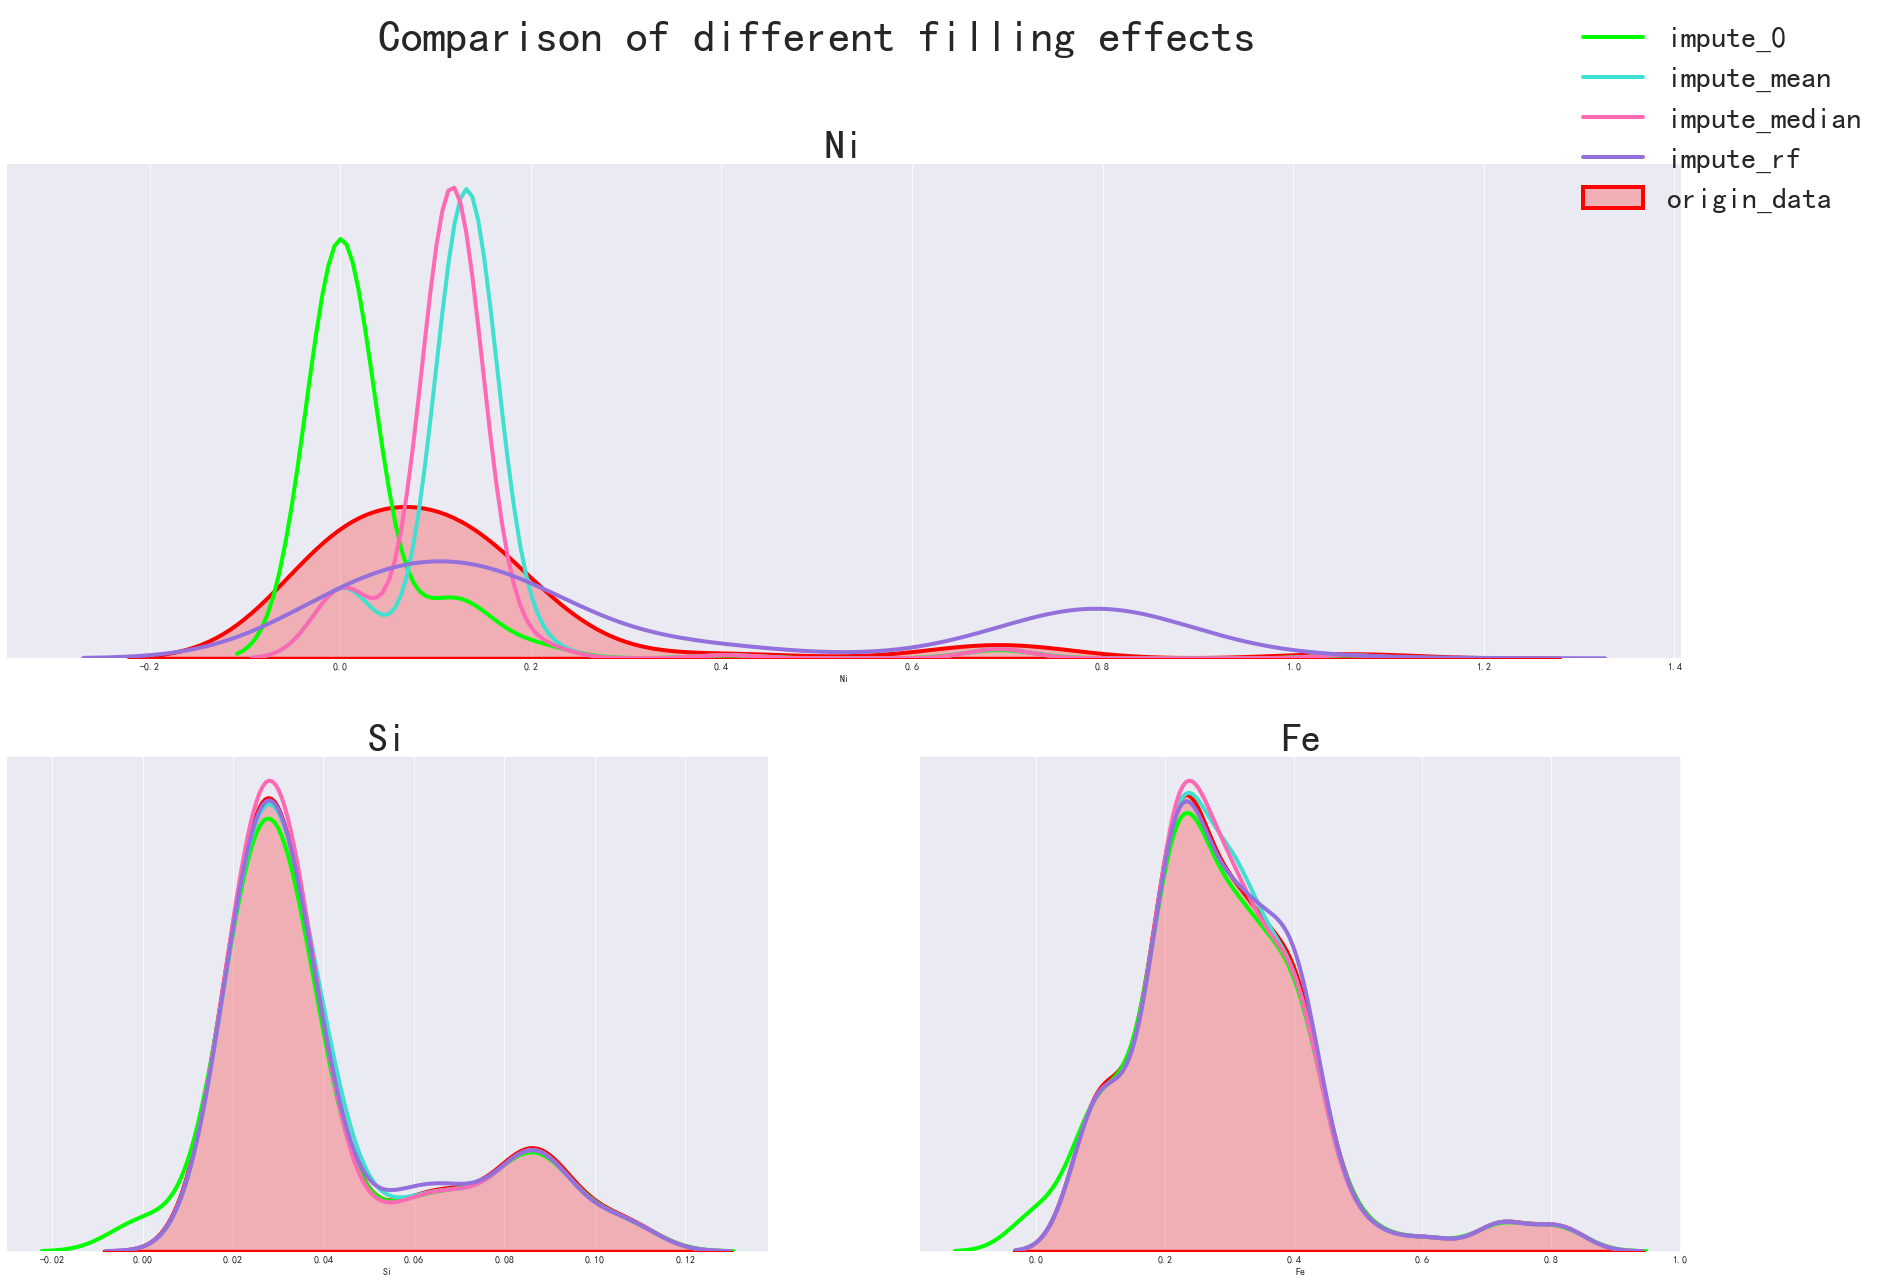

In [358]:
# ============ 各填充后的数据与原始数据分布对比图 =================
distribution_comp(data_iacs_l, label_names)

### 对数据data_ys的缺失值处理

In [68]:
# 对data_ys中的缺失值的统计
data_ys_miss_count = count_null(data_ys)
data_ys_miss_count

,features,miss_count,miss_proportion
0,Ni,275,0.690955
1,Si,19,0.047739
2,Fe,15,0.037688
3,Cr,0,0.0
4,Ti,0,0.0
5,固溶温度,0,0.0
6,固溶时间min,0,0.0
7,1级冷轧变形率,0,0.0
8,1级时效温度,0,0.0
9,1级时效时间h,0,0.0


In [326]:
# ======== 使用不同缺失值填充后的效果对比 ========
# 使用0填充
data_ys_0 = data_ys.fillna(0)

data_ys_miss_mean = data_ys[data_ys_miss_count["features"][:3]]
data_ys_miss_median = data_ys_miss_mean.copy()
for col in data_ys_miss_mean.columns:
    # 使用均值填充
    data_ys_miss_mean.loc[:, col].fillna(data_ys_miss_mean.loc[:, col].mean(), inplace = True)
    # 使用中值填充
    data_ys_miss_median.loc[:, col].fillna(data_ys_miss_median.loc[:, col].median(), inplace = True)
    
data_ys_mean = pd.concat([data_ys_miss_mean, data_ys[data_ys_miss_count["features"][3:]]], axis = 1)
data_ys_median = pd.concat([data_ys_miss_median, data_ys[data_ys_miss_count["features"][3:]]], axis = 1)

In [327]:
# 使用随机森林填充
data_ys_reg = data_ys.copy()
miss_cols = data_ys_miss_count.sort_values(by = "miss_proportion").iloc[-3:]["features"].tolist()
impute_of_rf(data_ys_reg, miss_cols)

In [335]:
col_names = data_ys_miss_count["features"][:3].tolist()
label_names = ["origin_data", "impute_0", "impute_mean", "impute_median", "impute_rf"]
data_ys_l = [data_ys[col_names], data_ys_0[col_names], data_ys_mean[col_names], 
         data_ys_median[col_names], data_ys_reg[col_names]]

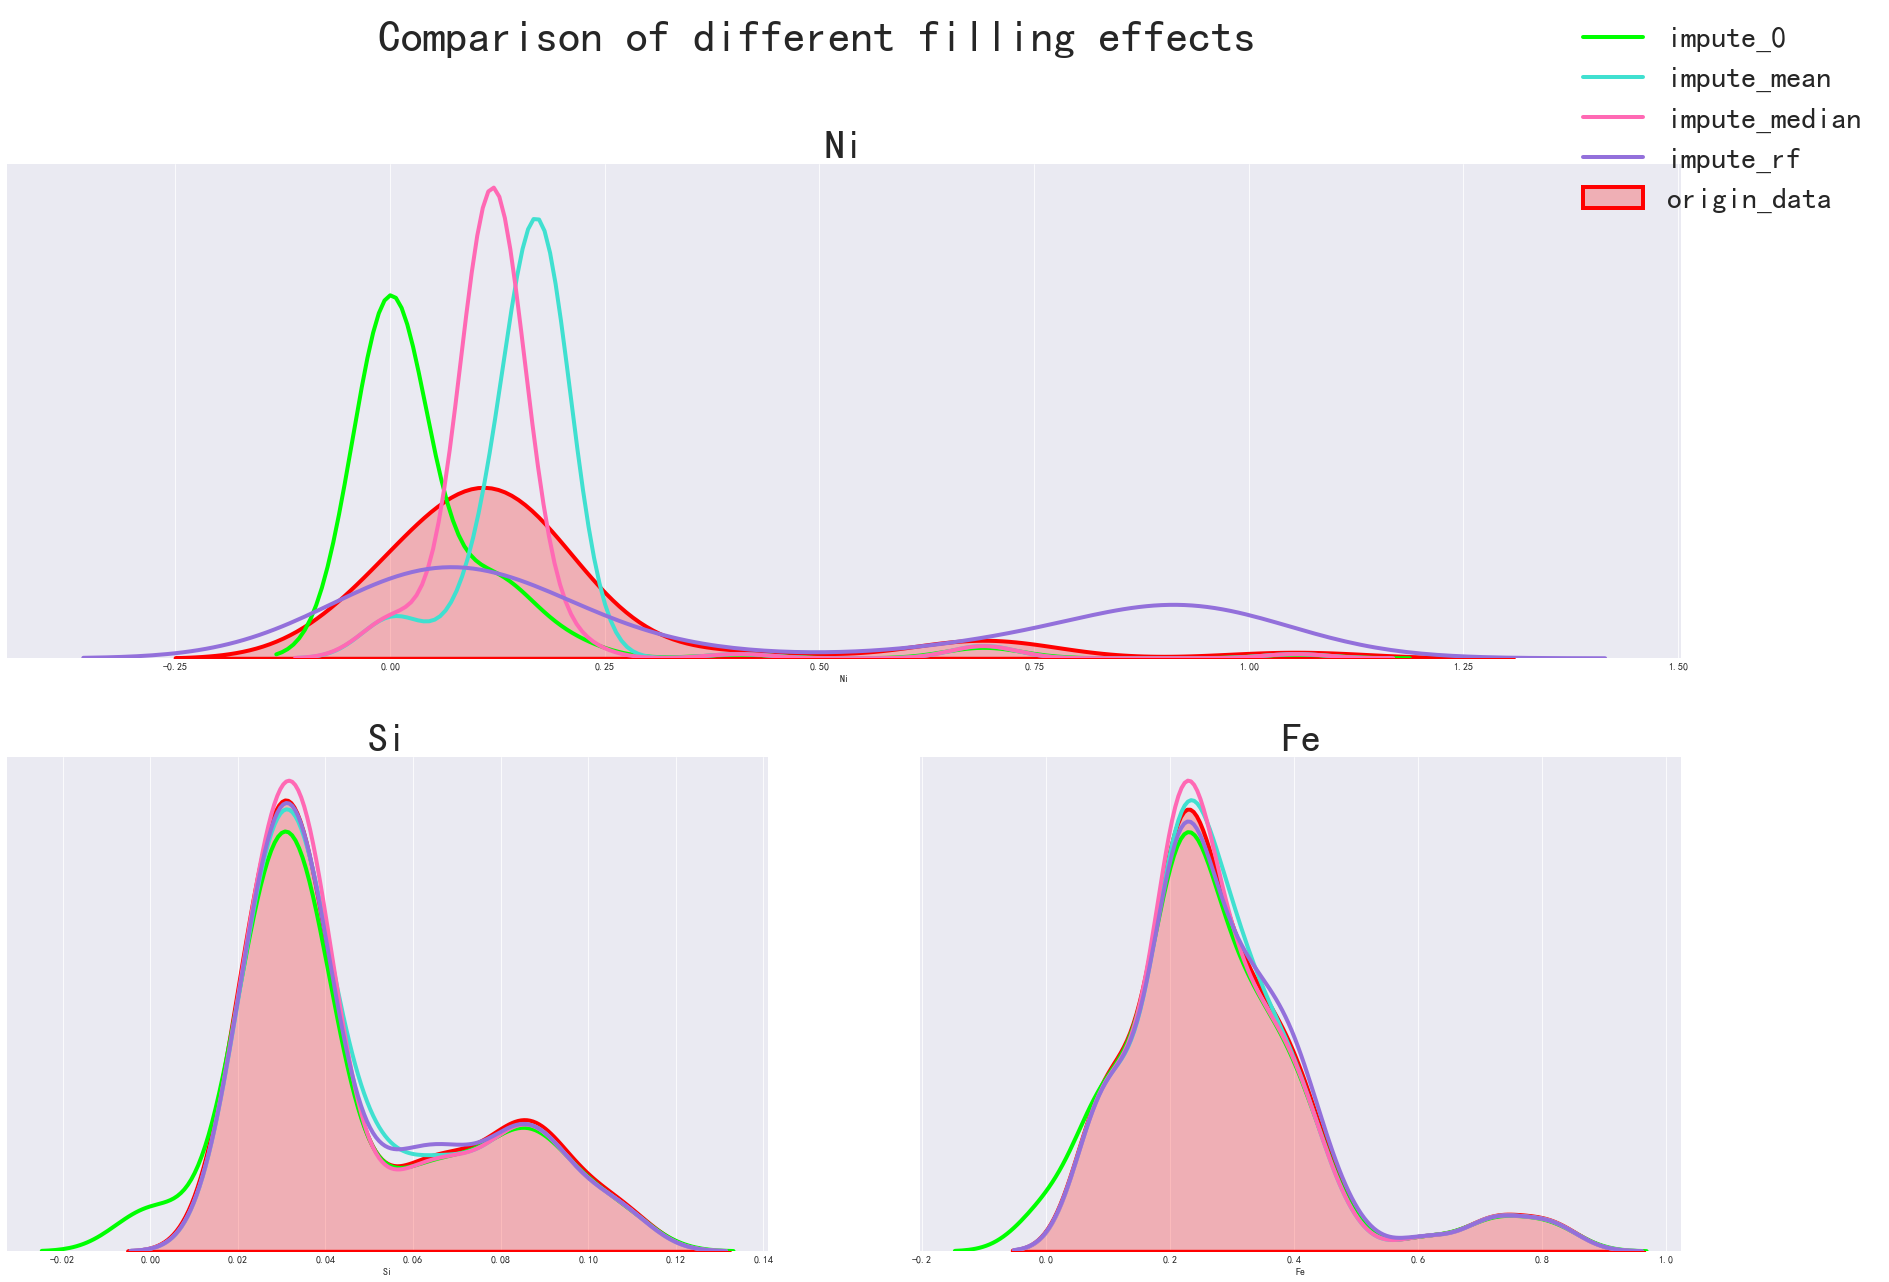

In [344]:
# ============ 各填充后的数据与原始数据分布对比图 =================
distribution_comp(data_ys_l, label_names)

# 不同填补策略效果对比

## 对数据data_iacs的填补效果对比

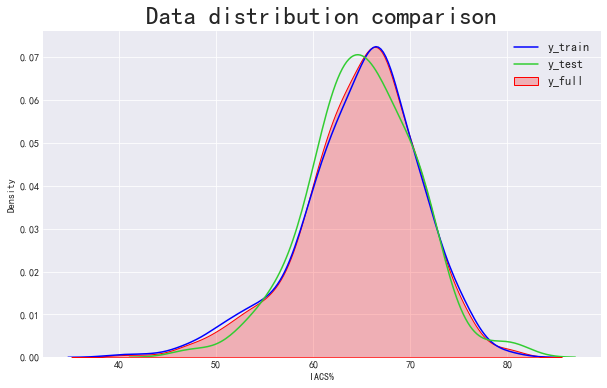

In [419]:
x_iacs_0, y_iacs_0 = data_iacs_0.iloc[:, :-1], data_iacs_0.iloc[:, -1]
x_iacs_mean, y_iacs_mean = data_iacs_mean.iloc[:, :-1], data_iacs_mean.iloc[:, -1]
x_iacs_median, y_iacs_median = data_iacs_median.iloc[:, :-1], data_iacs_median.iloc[:, -1]
x_iacs_reg, y_iacs_reg = data_iacs_reg.iloc[:, :-1], data_iacs_reg.iloc[:, -1]
# 划分训练测试集
x_iacs_train_0, x_iacs_test_0, y_iacs_train_0, y_iacs_test_0 = data_split(x_iacs_0, y_iacs_0, False, rand_ = 9)
x_iacs_train_mean, x_iacs_test_mean, y_iacs_train_mean, y_iacs_test_mean = data_split(x_iacs_mean, y_iacs_mean, False, rand_ = 9)
x_iacs_train_median, x_iacs_test_median, y_iacs_train_median, y_iacs_test_median = data_split(x_iacs_median, y_iacs_median, False, rand_ = 9)
x_iacs_train_reg, x_iacs_test_reg, y_iacs_train_reg, y_iacs_test_reg = data_split(x_iacs_reg, y_iacs_reg, True, rand_ = 9)

In [472]:
train_df_list = []
validate_df_list = []
test_df_list = []
# 计算不同填充法得到的数据集在交叉验证和测试集上的各指标的结果
for xtr, xte, ytr, yte in [[x_iacs_train_0, x_iacs_test_0, y_iacs_train_0, y_iacs_test_0],
                           [x_iacs_train_mean, x_iacs_test_mean, y_iacs_train_mean, y_iacs_test_mean],
                           [x_iacs_train_median, x_iacs_test_median, y_iacs_train_median, y_iacs_test_median],
                           [x_iacs_train_reg, x_iacs_test_reg, y_iacs_train_reg, y_iacs_test_reg]]:
    train_df, validate_df = multi_models_predict(xtr, xte, ytr, yte, target_name="IACS")
    # 计算模型在测试集上的表现
    test_df = multi_models_predict(xtr, xte, ytr, yte , target_name="IACS", return_test=True)
    
    train_df_list.append(train_df)
    validate_df_list.append(validate_df)
    test_df_list.append(test_df)
    
iacs_train_df_0 = train_df_list[0]
iacs_train_df_mean = train_df_list[1]
iacs_train_df_median = train_df_list[2]
iacs_train_df_reg = train_df_list[3]

iacs_validate_df_0 = validate_df_list[0]
iacs_validate_df_mean = validate_df_list[1]
iacs_validate_df_median = validate_df_list[2]
iacs_validate_df_reg = validate_df_list[3]

iacs_test_df_0 = test_df_list[0]
iacs_test_df_mean = test_df_list[1]
iacs_test_df_median = test_df_list[2]
iacs_test_df_reg = test_df_list[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [473]:
iacs_validate_df_0

,IACS_Validate MAE,MAPE,R^2
Ridge,3.179486,0.051187,0.531680
Lasso,4.406625,0.070551,0.117444
Huber,2.963572,0.047758,0.547016
Linear_SVR,4.556549,0.071894,0.067768
SVR,4.676001,0.076433,-0.020300
RandomForest,1.767054,0.028465,0.825750
AdaBoost,2.794127,0.044005,0.657140
GBDT,1.701124,0.027085,0.838750
Bagging,1.766685,0.028460,0.825677
XGBoost,1.505183,0.024136,0.855984


In [474]:
iacs_validate_df_mean

,IACS_Validate MAE,MAPE,R^2
Ridge,3.073240,0.049301,0.560338
Lasso,4.406625,0.070551,0.117444
Huber,2.959911,0.047383,0.552792
Linear_SVR,4.551252,0.071788,0.071755
SVR,4.676000,0.076433,-0.020300
RandomForest,1.773470,0.028621,0.824406
AdaBoost,2.826105,0.044466,0.658024
GBDT,1.687487,0.026966,0.834010
Bagging,1.783669,0.028792,0.823547
XGBoost,1.553765,0.024848,0.845973


In [475]:
iacs_validate_df_median

,IACS_Validate MAE,MAPE,R^2
Ridge,3.076088,0.049366,0.559135
Lasso,4.406625,0.070551,0.117444
Huber,2.945878,0.047346,0.574047
Linear_SVR,4.551521,0.071796,0.071472
SVR,4.676000,0.076433,-0.020300
RandomForest,1.781918,0.028741,0.824065
AdaBoost,2.848634,0.044935,0.644289
GBDT,1.675254,0.026694,0.836649
Bagging,1.777322,0.028657,0.826134
XGBoost,1.527610,0.024417,0.850282


In [476]:
iacs_validate_df_reg

,IACS_Validate MAE,MAPE,R^2
Ridge,3.067217,0.049243,0.554595
Lasso,4.406625,0.070551,0.117444
Huber,3.120538,0.049894,0.539218
Linear_SVR,4.589330,0.072104,0.064409
SVR,4.675996,0.076433,-0.020298
RandomForest,1.825880,0.029666,0.810938
AdaBoost,2.894704,0.045803,0.647517
GBDT,1.889314,0.030463,0.796916
Bagging,1.817771,0.029521,0.811500
XGBoost,1.626698,0.026248,0.840336


In [498]:
iacs_test_df_0

,(IACS_Test) MAE,MAPE
Ridge,2.664591,0.041205
Lasso,3.983105,0.062010
Huber,2.372510,0.036319
Linear_SVR,9.085068,0.146336
SVR,4.319816,0.068314
RandomForest,1.444359,0.022160
AdaBoost,2.526715,0.038928
GBDT,1.343197,0.020453
Bagging,1.421283,0.021822
XGBoost,1.174068,0.018078


In [499]:
iacs_test_df_mean

,(IACS_Test) MAE,MAPE
Ridge,2.521940,0.038767
Lasso,3.983105,0.062010
Huber,2.373470,0.036412
Linear_SVR,9.021919,0.145320
SVR,4.319816,0.068314
RandomForest,1.450564,0.022289
AdaBoost,2.577936,0.039822
GBDT,1.321321,0.020237
Bagging,1.455326,0.022367
XGBoost,1.142877,0.017599


In [500]:
iacs_test_df_median

,(IACS_Test) MAE,MAPE
Ridge,2.526020,0.038838
Lasso,3.983105,0.062010
Huber,2.364309,0.036243
Linear_SVR,9.028214,0.145422
SVR,4.319816,0.068314
RandomForest,1.454351,0.022340
AdaBoost,2.731655,0.042305
GBDT,1.397268,0.021407
Bagging,1.455692,0.022392
XGBoost,1.193285,0.018516


In [501]:
iacs_test_df_reg

,(IACS_Test) MAE,MAPE
Ridge,2.875599,0.045171
Lasso,3.983105,0.062010
Huber,2.978624,0.046774
Linear_SVR,8.918448,0.143653
SVR,4.319814,0.068314
RandomForest,1.519193,0.023435
AdaBoost,3.129545,0.048640
GBDT,1.448804,0.022365
Bagging,1.520349,0.023472
XGBoost,1.224362,0.019052


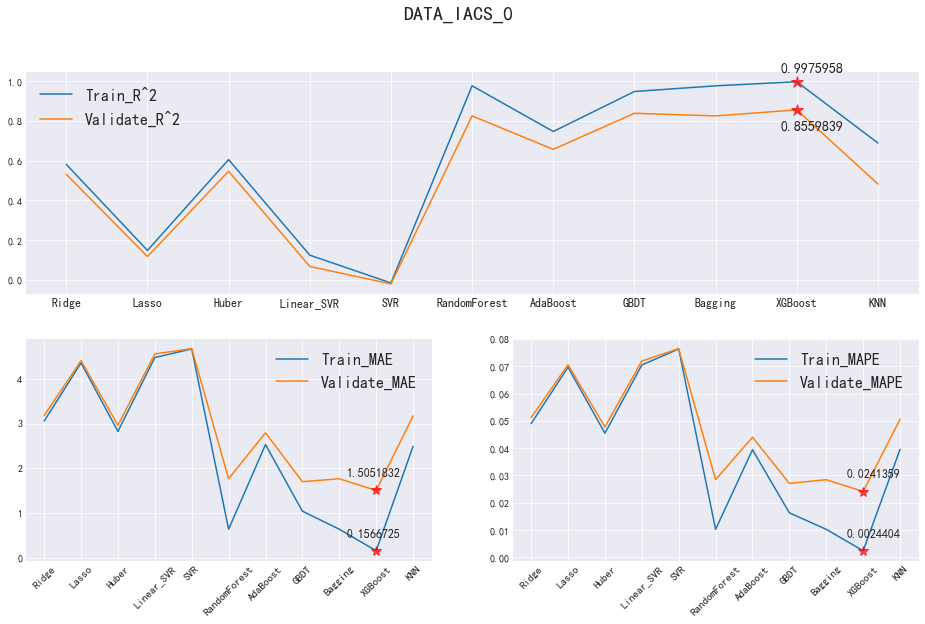

In [589]:
train_validate_comp(iacs_train_df_0, iacs_validate_df_0, "DATA_IACS_0")

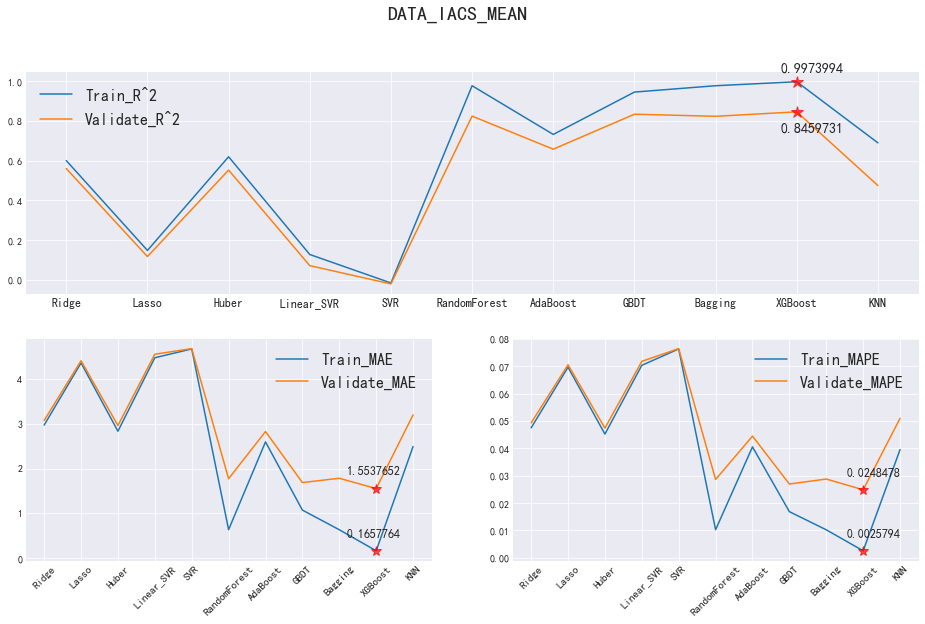

In [590]:
train_validate_comp(iacs_train_df_mean, iacs_validate_df_mean, "DATA_IACS_MEAN")

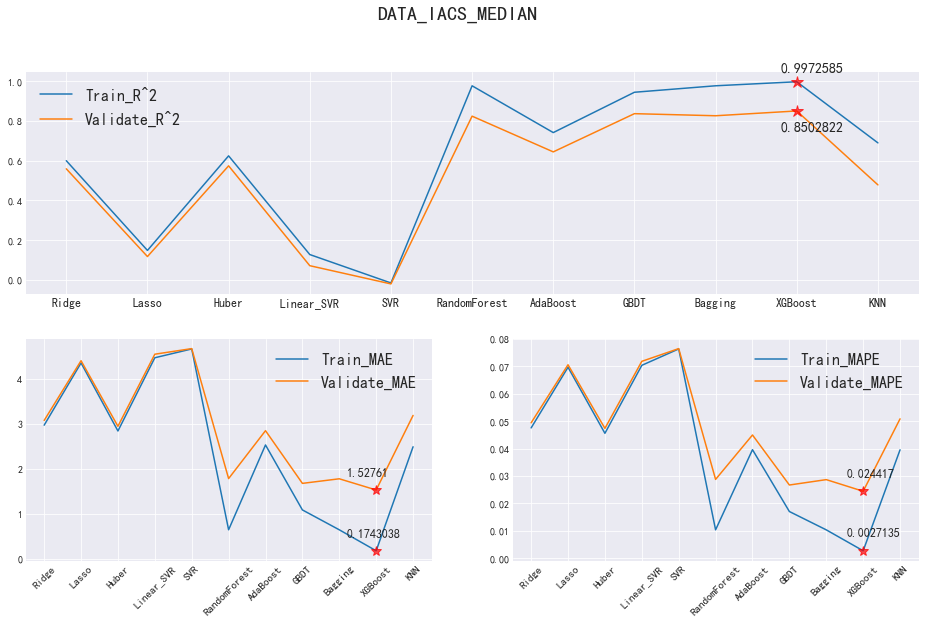

In [591]:
train_validate_comp(iacs_train_df_median, iacs_validate_df_median, "DATA_IACS_MEDIAN")

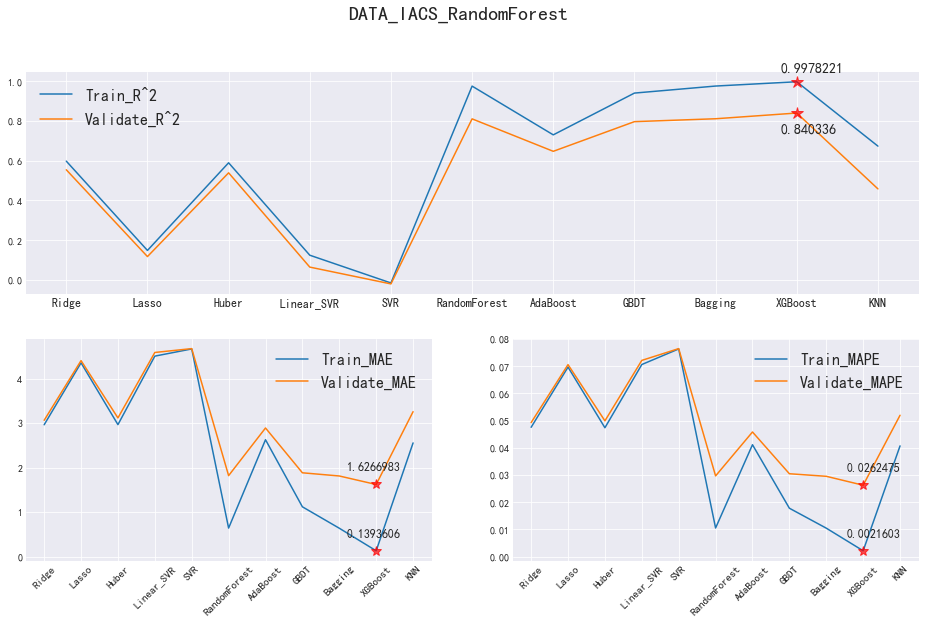

In [592]:
train_validate_comp(iacs_train_df_reg, iacs_validate_df_reg, "DATA_IACS_RandomForest")

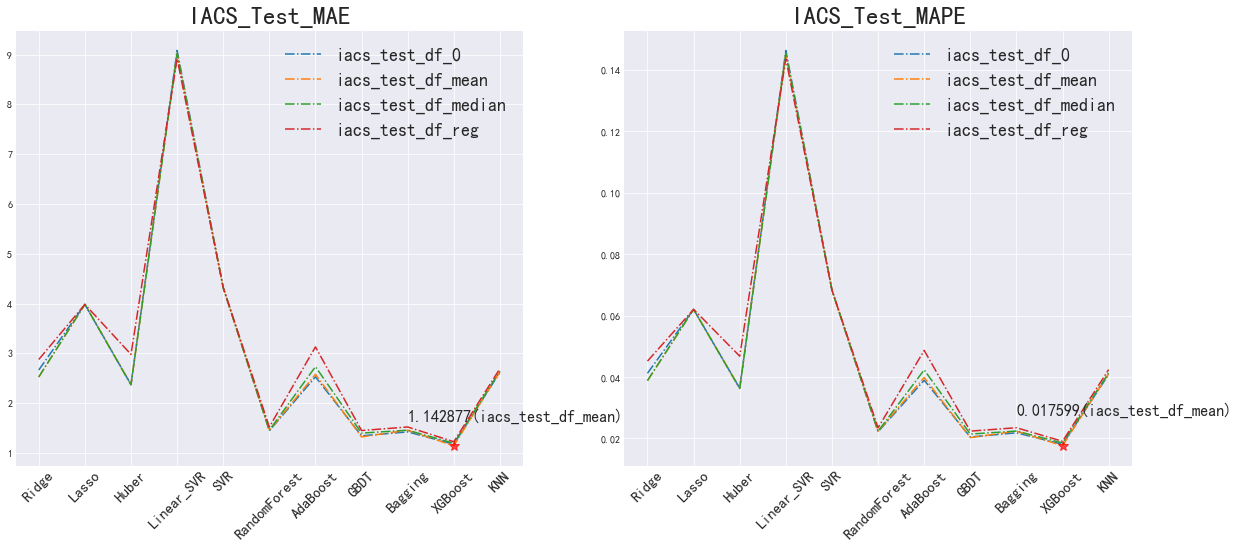

In [661]:
# ========= 各模型在不同数据集上的表现 =========
plt.figure(figsize = (20, 8))
labels = ["iacs_test_df_0", "iacs_test_df_mean", "iacs_test_df_median", "iacs_test_df_reg"]
titles = ["Test_MAE", "Test_MAPE"]
y_min = 1e3

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    for j, dat in enumerate([iacs_test_df_0, iacs_test_df_mean, iacs_test_df_median, iacs_test_df_reg]):
        ax.plot(dat.iloc[:, i], label = labels[j], ls = "-.")
        # 最小值索引
        idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
        t_min = dat.iloc[:, i].min()
        # 找出4个数据中同一指标下的最小值并标出
        if y_min > t_min:
            min_idx = idx
            y_min = t_min
            k = j # 用来记录最小值是哪个df中的
    ax.plot(min_idx, y_min, marker = "*", color = "red", markersize = 11, alpha = .7)
    d = 0.5
    if i == 1:
        d = 0.01
    ax.text(min_idx - 1, y_min + d, str(round(y_min, 6)) + "(" + labels[k] + ")", fontsize = 16)
    ax.tick_params("x", rotation = 45, labelsize = 15)
    ax.legend(fontsize = 18)
    ax.set_title("IACS_" + titles[i], fontsize = 25)
plt.show()

> 如图所示，表现最好的是使用0填充和使用中值填充，而在指标MAE和MAPE上，0填充的效果较中值填充的要稍好一些；并且在测试集上的表现也是如此，因此可以确定填补策略使用0填充法，并使用XGBoost进行后序的建模训练；

## 对数据data_ys的填补效果对比

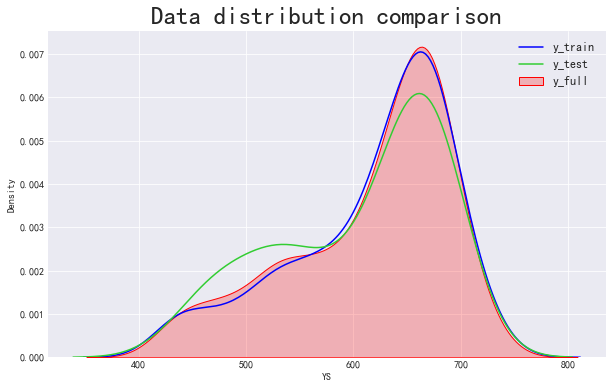

In [505]:
x_ys_0, y_ys_0 = data_ys_0.iloc[:, :-1], data_ys_0.iloc[:, -1]
x_ys_mean, y_ys_mean = data_ys_mean.iloc[:, :-1], data_ys_mean.iloc[:, -1]
x_ys_median, y_ys_median = data_ys_median.iloc[:, :-1], data_ys_median.iloc[:, -1]
x_ys_reg, y_ys_reg = data_ys_reg.iloc[:, :-1], data_ys_reg.iloc[:, -1]
# 划分训练测试集
x_ys_train_0, x_ys_test_0, y_ys_train_0, y_ys_test_0 = data_split(x_ys_0, y_ys_0, False, rand_ = 9)
x_ys_train_mean, x_ys_test_mean, y_ys_train_mean, y_ys_test_mean = data_split(x_ys_mean, y_ys_mean, False, rand_ = 9)
x_ys_train_median, x_ys_test_median, y_ys_train_median, y_ys_test_median = data_split(x_ys_median, y_ys_median, False, rand_ = 9)
x_ys_train_reg, x_ys_test_reg, y_ys_train_reg, y_ys_test_reg = data_split(x_ys_reg, y_ys_reg, True, rand_ = 9)

In [506]:
ys_train_df_list = []
ys_validate_df_list = []
ys_test_df_list = []
# 计算不同填充法得到的数据集在交叉验证和测试集上的各指标的结果
for xtr, xte, ytr, yte in [[x_ys_train_0, x_ys_test_0, y_ys_train_0, y_ys_test_0],
                           [x_ys_train_mean, x_ys_test_mean, y_ys_train_mean, y_ys_test_mean],
                           [x_ys_train_median, x_ys_test_median, y_ys_train_median, y_ys_test_median],
                           [x_ys_train_reg, x_ys_test_reg, y_ys_train_reg, y_ys_test_reg]]:
    train_df, validate_df = multi_models_predict(xtr, xte, ytr, yte, target_name="IACS")
    # 计算模型在测试集上的表现
    test_df = multi_models_predict(xtr, xte, ytr, yte , target_name="IACS", return_test=True)
    
    ys_train_df_list.append(train_df)
    ys_validate_df_list.append(validate_df)
    ys_test_df_list.append(test_df)
    
ys_train_df_0 = ys_train_df_list[0]
ys_train_df_mean = ys_train_df_list[1]
ys_train_df_median = ys_train_df_list[2]
ys_train_df_reg = ys_train_df_list[3]

ys_validate_df_0 = ys_validate_df_list[0]
ys_validate_df_mean = ys_validate_df_list[1]
ys_validate_df_median = ys_validate_df_list[2]
ys_validate_df_reg = ys_validate_df_list[3]

ys_test_df_0 = ys_test_df_list[0]
ys_test_df_mean = ys_test_df_list[1]
ys_test_df_median = ys_test_df_list[2]
ys_test_df_reg = ys_test_df_list[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [507]:
ys_validate_df_0

,IACS_Validate MAE,MAPE,R^2
Ridge,27.504784,0.047067,0.777979
Lasso,27.091698,0.046737,0.775510
Huber,26.722347,0.045164,0.783409
Linear_SVR,54.759920,0.096724,0.000693
SVR,57.364365,0.104533,-0.104230
RandomForest,15.425826,0.025635,0.921091
AdaBoost,19.026969,0.031526,0.886654
GBDT,15.119378,0.024946,0.923151
Bagging,15.414724,0.025615,0.921182
XGBoost,15.443657,0.025636,0.918551


In [508]:
ys_validate_df_mean

,IACS_Validate MAE,MAPE,R^2
Ridge,27.172713,0.046628,0.778698
Lasso,27.091698,0.046737,0.775510
Huber,25.106264,0.042570,0.812959
Linear_SVR,54.617148,0.093413,0.083892
SVR,57.364363,0.104533,-0.104229
RandomForest,15.464171,0.025681,0.919064
AdaBoost,19.382477,0.032235,0.887325
GBDT,15.189597,0.024940,0.922573
Bagging,15.422301,0.025604,0.920106
XGBoost,15.532119,0.025805,0.915111


In [509]:
ys_validate_df_median

,IACS_Validate MAE,MAPE,R^2
Ridge,27.363439,0.046921,0.777667
Lasso,27.091698,0.046737,0.775510
Huber,25.201245,0.042644,0.811907
Linear_SVR,54.458308,0.092676,0.141297
SVR,57.364364,0.104533,-0.104230
RandomForest,15.362218,0.025515,0.920496
AdaBoost,19.666336,0.032894,0.885394
GBDT,15.369859,0.025260,0.921955
Bagging,15.437364,0.025634,0.919838
XGBoost,15.611855,0.025972,0.917957


In [510]:
ys_validate_df_reg

,IACS_Validate MAE,MAPE,R^2
Ridge,26.725308,0.045945,0.779265
Lasso,26.975666,0.046590,0.773175
Huber,25.080442,0.042491,0.809013
Linear_SVR,47.564469,0.084498,0.242720
SVR,57.364351,0.104533,-0.104229
RandomForest,13.806070,0.023275,0.932479
AdaBoost,19.045849,0.031943,0.886789
GBDT,14.002393,0.023348,0.933744
Bagging,13.781927,0.023236,0.932597
XGBoost,13.626228,0.022926,0.936480


In [511]:
ys_test_df_0

,(IACS_Test) MAE,MAPE
Ridge,24.310007,0.043224
Lasso,23.738939,0.042643
Huber,22.204195,0.038993
Linear_SVR,62.845231,0.116540
SVR,63.013563,0.117769
RandomForest,15.050877,0.025671
AdaBoost,21.651438,0.037370
GBDT,13.372966,0.022831
Bagging,15.144033,0.025846
XGBoost,13.766208,0.023263


In [512]:
ys_test_df_mean

,(IACS_Test) MAE,MAPE
Ridge,23.350918,0.041748
Lasso,23.738939,0.042643
Huber,22.259799,0.039043
Linear_SVR,49.344834,0.085663
SVR,63.013559,0.117769
RandomForest,14.920409,0.025476
AdaBoost,18.600481,0.031963
GBDT,13.528420,0.023093
Bagging,14.842843,0.025378
XGBoost,14.327465,0.024290


In [513]:
ys_test_df_median

,(IACS_Test) MAE,MAPE
Ridge,23.453931,0.041949
Lasso,23.738939,0.042643
Huber,22.560861,0.039633
Linear_SVR,44.058871,0.082821
SVR,63.013560,0.117769
RandomForest,14.867283,0.025383
AdaBoost,19.951176,0.034390
GBDT,13.409402,0.022923
Bagging,15.010014,0.025650
XGBoost,14.545156,0.024627


In [514]:
ys_test_df_reg

,(IACS_Test) MAE,MAPE
Ridge,23.821304,0.042354
Lasso,24.012480,0.043035
Huber,22.624831,0.039479
Linear_SVR,89.991759,0.143226
SVR,63.013544,0.117769
RandomForest,13.703387,0.023675
AdaBoost,18.244157,0.031826
GBDT,12.551882,0.021579
Bagging,13.874112,0.023956
XGBoost,12.988782,0.021945


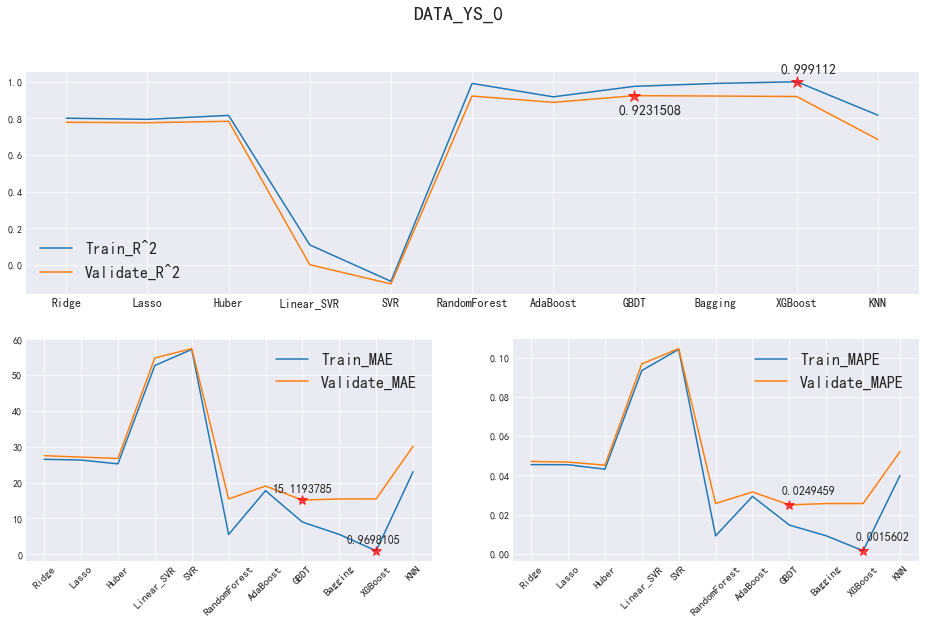

In [543]:
train_validate_comp(ys_train_df_0, ys_validate_df_0, "DATA_YS_0")

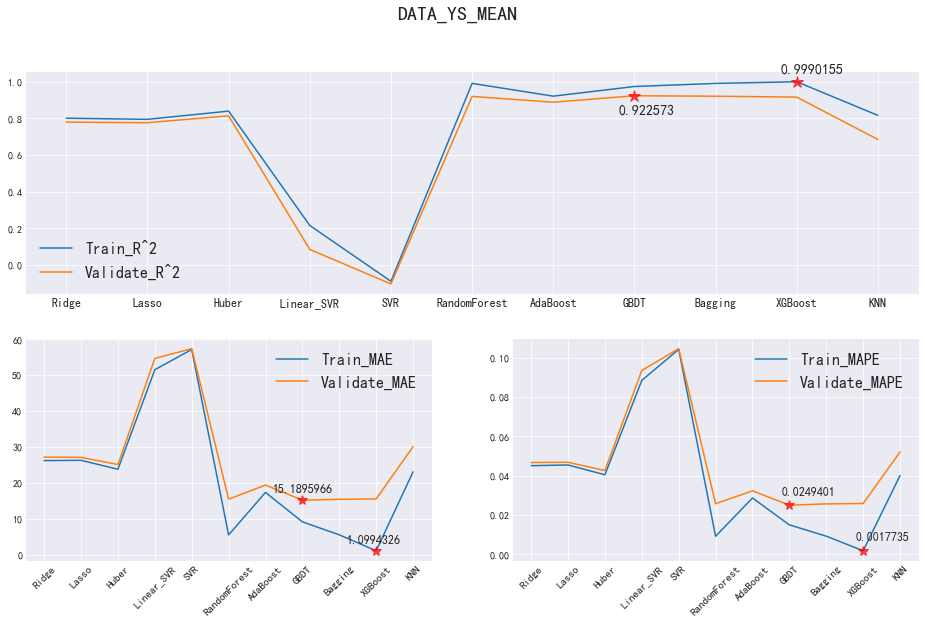

In [544]:
train_validate_comp(ys_train_df_mean, ys_validate_df_mean, "DATA_YS_MEAN")

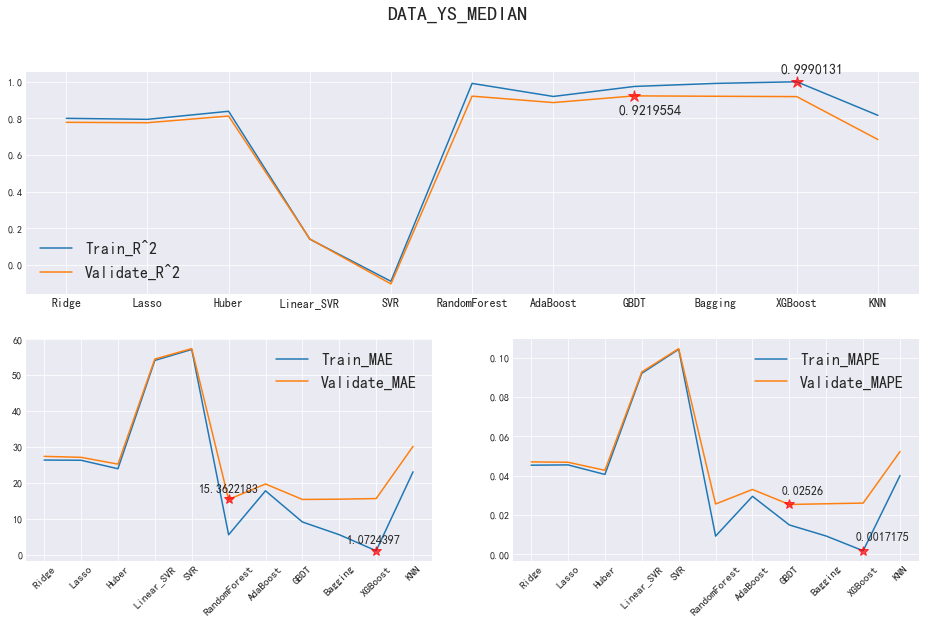

In [545]:
train_validate_comp(ys_train_df_median, ys_validate_df_median, "DATA_YS_MEDIAN")

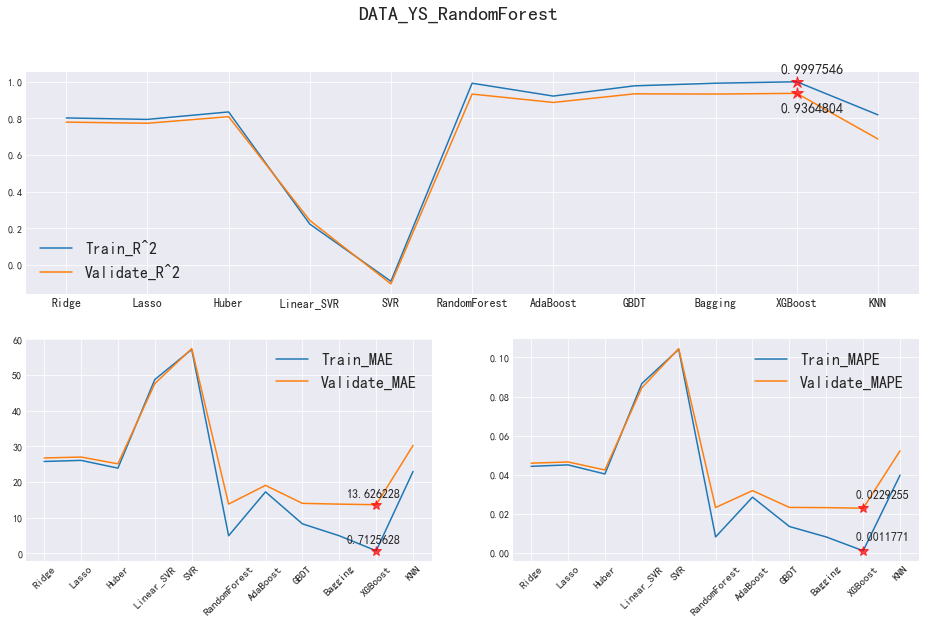

In [546]:
train_validate_comp(ys_train_df_reg, ys_validate_df_reg, "DATA_YS_RandomForest")

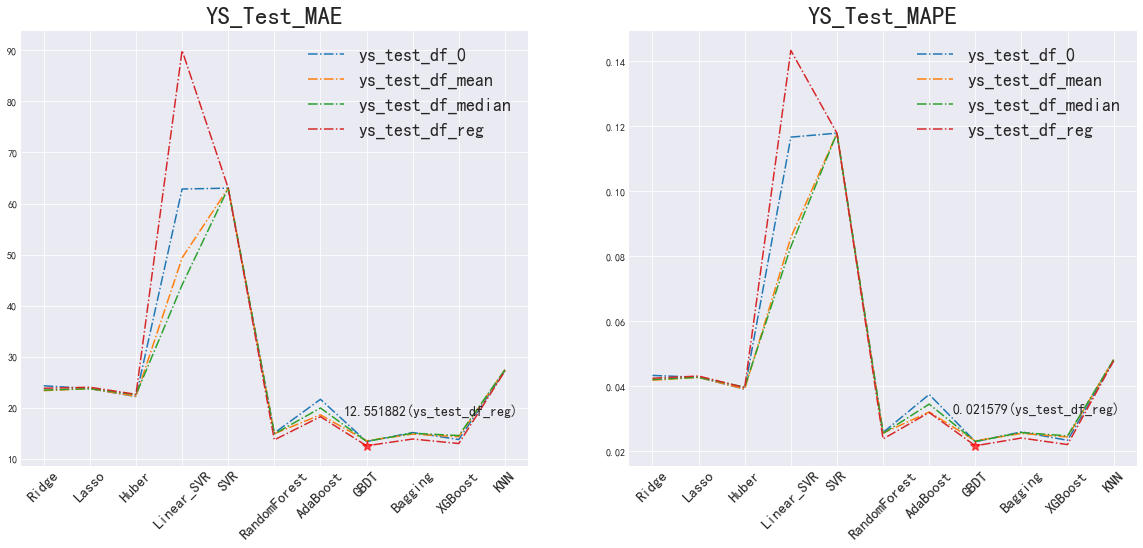

In [663]:
plt.figure(figsize = (20, 8))
labels = ["ys_test_df_0", "ys_test_df_mean", "ys_test_df_median", "ys_test_df_reg"]
titles = ["Test_MAE", "Test_MAPE"]
y_min = 1e3

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    for j, dat in enumerate([ys_test_df_0, ys_test_df_mean, ys_test_df_median, ys_test_df_reg]):
        ax.plot(dat.iloc[:, i], label = labels[j], ls = "-.")
        # 最小值索引
        idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
        t_min = dat.iloc[:, i].min()
        # 找出4个数据中同一指标下的最小值并标出
        if y_min > t_min:
            min_idx = idx
            y_min = t_min
            k = j # 用来记录最小值是哪个df中的
    ax.plot(min_idx, y_min, marker = "*", color = "red", markersize = 11, alpha = .7)
    d = 6
    if i == 1:
        d = 0.01
    ax.text(min_idx - 0.5, y_min + d, str(round(y_min, 6)) + "(" + labels[k] + ")", fontsize = 14)
    ax.tick_params("x", rotation = 45, labelsize = 15)
    ax.legend(fontsize = 18)
    ax.set_title("YS_" + titles[i], fontsize = 25)
plt.show()

> 如图所示，显示在所有模型当中树模型的效果要显著好于其它模型，并且最好的模型是GBDT和XGBoost，但相比之下，XGBoost要稍胜一筹，在还未有任何调参的情况下R^2值就已经达到了93%以上，但在测试集上是GBDT要更好一点，但其实差距非常之小，因此可以确定填补策略选用以随机森林进行填补，并以XGBoost参与后序的建模及调优；

# 特征筛选

## 对data_iacs_0的特征筛选

In [606]:
rand_ = 72
xgb = XGB(random_state = rand_)
# 嵌入法
embed = SelectFromModel(xgb)
x_iacs_train_embed = embed.fit_transform(x_iacs_train_0, y_iacs_train_0)
idxes = embed.get_support(indices = True)
col_names = []
for i in idxes:
    col_names.append(x_iacs_train_0.columns[i])
x_iacs_train_embed = pd.DataFrame(x_iacs_train_embed, columns = col_names)

# 包装法
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
wrapper = RFECV(xgb, cv = cv).fit(x_iacs_train_0, y_iacs_train_0)
idxes = wrapper.get_support(indices = True)
x_iacs_train_wrapper = wrapper.transform(x_iacs_train_0)
col_names = []
for i in idxes:
    col_names.append(x_iacs_train_0.columns[i])
x_iacs_train_wrapper = pd.DataFrame(x_iacs_train_wrapper, columns = col_names)

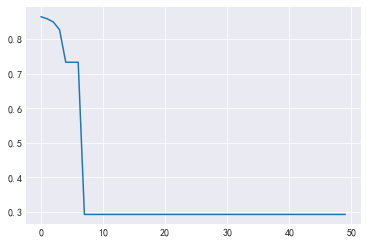

In [619]:
l = []

for i in np.linspace(0.0001, 0.3, 50):
    var = VarianceThreshold(threshold = i)
    x_var = var.fit_transform(x_iacs_train_0)
    res = cross_validate(xgb, X = x_var, y = y_iacs_train_0, cv = 5, scoring = "r2")
    l.append(res["test_score"].mean())
    
plt.plot(l)
plt.show()

> 由图可见，只要有特征被筛选掉，模型的表现一定会降低，说明当前特征对模型来说都是有用的，不能剔除，包装法所得结果也是一样，保留了全部特征，嵌入法虽然过滤掉了特征，但模型效力明显下降，因此保留所有特征，不进行特征过滤；

## 对data_ys_reg的特征筛选

In [634]:
rand_ = 72
xgb = XGB(random_state = rand_)
# 嵌入法
embed = SelectFromModel(xgb)
x_ys_train_embed = embed.fit_transform(x_ys_train_reg, y_ys_train_reg)
idxes = embed.get_support(indices = True)
col_names = []
for i in idxes:
    col_names.append(x_ys_train_0.columns[i])
x_ys_train_embed = pd.DataFrame(x_ys_train_embed, columns = col_names)

# 包装法
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
wrapper = RFECV(xgb, cv = cv).fit(x_ys_train_reg, y_ys_train_reg)
idxes = wrapper.get_support(indices = True)
x_ys_train_wrapper = wrapper.transform(x_ys_train_reg)
col_names = []
for i in idxes:
    col_names.append(x_ys_train_reg.columns[i])
x_ys_train_wrapper = pd.DataFrame(x_ys_train_wrapper, columns = col_names)

In [644]:
x_ys_train_wrapper.shape[1]

13

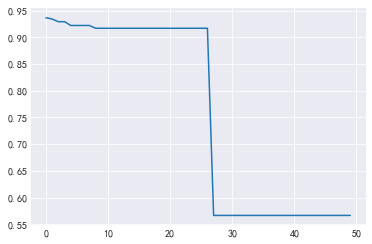

In [640]:
l = []
# 方差过滤
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
for i in np.linspace(0.0001, 0.3, 50):
    var = VarianceThreshold(threshold = i)
    x_var = var.fit_transform(x_ys_train_reg)
    res = cross_validate(xgb, X = x_var, y = y_ys_train_reg, cv = cv, scoring = "r2", n_jobs = 32)
    l.append((res["test_score"].mean(), i))
    
plt.plot(pd.DataFrame(l).iloc[:, 0])
plt.show()

In [641]:
l.index(max(l))

0

> 由上可见，包装法和方差过滤得到的结果都是一样的，而嵌入法虽然过滤掉了一部分特征，但显然其模型表现骤然下降，因此对于data_ys_reg数据集，将保留所有数据参与后面的建模调优；

# 数据保存

In [580]:
path = r"C:\Users\Research Center\Desktop\learning\PW770建模\对标签YS&IACS建模分析\1.建模数据处理"
for dat, tag in zip([data_iacs_0, data_ys_reg], ["data_iacs_0.xlsx", "data_ys_reg.xlsx"]):
    dat.to_excel(os.path.join(path, tag))